In [9]:
Student_1 = 'Andy' #@param {type:"string"}  Name of student 1
Student_2 = 'Yin Li' #@param {type:"string"}  Name of student 2
Student_3 = '' #@param {type:"string"}  Name of student 3
Student_4 = '' #@param {type:"string"}  Name of student 4

# Overvew

This is the skeleton code file for the EE4802/IE4213 assignment. Replace the `XX`. in the name of this Colab notebook with your group number (this is important for correct marks to be awarded to your group). Fill in the blank cells below with the necessary code (you should work on this Colab notebook section by section). At the end, the entire Colab notebook should generate all the required results and execute without error.

The text above the blank cells provides information on the functionality that needs to be implemented. You need to write Python code at places indicated by `[WriteCode]`

## Install and Import Libraries

In [10]:
%%capture
# %%capture hides the output
# install visulization tool
%pip install renderlab


In [11]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import os
import time
import numpy as np
import random
from collections import deque

import gymnasium as gym
import renderlab as rl

ModuleNotFoundError: No module named 'moviepy.editor'

# Background

## Environment Exploration: Cart-Pole

The **Cart-Pole environment** is a classic reinforcement learning problem where a pole is attached by an un-actuated joint to a cart. The cart moves along a frictionless track, and the goal is to balance the pole upright by applying forces to move the cart left or right.

<img src="https://gymnasium.farama.org/_images/cart_pole.gif" width="400">

Below is a breakdown of the base Cart-Pole environment:


#### - **Observation Space (*s*)**
The observation is represented as a `ndarray` of shape `(4,)`, corresponding to:
- **Cart Position**: Horizontal location of the cart.
- **Cart Velocity**: Speed of the cart along the track.
- **Pole Angle**: Angular position of the pole relative to vertical.
- **Pole Angular Velocity**: Speed at which the pole angle changes.

The observations are initialized with uniformly random values in the range `(-0.05, 0.05)`.


#### - **Action Space (*a*)**
The action is a discrete value (`0` or `1`) indicating the direction of the force applied to the cart:
- `0`: Push the cart to the left.
- `1`: Push the cart to the right.



#### - **Reward Function (*r*)**
The agent receives a reward of `+1` for each time step it successfully keeps the pole upright. The maximum achievable reward in a single episode is `500`.

#### - **Episode Termination (*isDone*)**
An episode ends if any of the following conditions occur:
1. **Pole Angle** exceeds `±12°`.
2. **Cart Position** exceeds `±2.4` (the cart reaches the edge of the track).
3. **Truncation**: The episode reaches the maximum length of `500 steps`.

## Getting Familiar with Basic Gym Usage

Let's observe how to interact with a Gym environment.

The classic “agent-environment loop” pictured below is a simplified representation of reinforcement learning that Gymnasium implements.

<img src="https://drive.google.com/uc?export=view&id=1feMbDMTfOFTBtj2PAZz-kMjSQKVukEm6" width="250">


The following section represents a simple episode of this loop, we will:

1. Import the base Cart-Pole environment from the gym library and explore its functionality.

2. Apply modifications to make the environment more challenging by adjusting the pole's dynamics and introducing stochastic forces.

3. Sample random actions to control the cart-pole and visualize the process using `renderlab`.

These steps will help us understand how the environment behaves under different conditions and prepare us for implementing reinforcement learning agents in later sections.



In [12]:
import warnings
warnings.filterwarnings('ignore')

# Import and Explore the Environment
print("\n--- Exploring the Base Environment ---")
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset()

# Print information about the environment
print(f"Initial Observation: {observation}")
print(f"Action Space: {env.action_space}")  # Discrete actions: 0 (left), 1 (right)
print(f"Observation Space: {env.observation_space}")  # State variables: cart position, etc.

# Sample Random Actions and Visualize
print("\n--- Sampling Random Actions and Visualizing ---")
env = rl.RenderFrame(env, "./output")
observation, info = env.reset()
isDone = False

# Simulate an episode with random actions
while not isDone:
    action = env.action_space.sample()  # Take random action
    observation, reward, terminated, truncated, info = env.step(action)
    print(observation, reward)
    isDone = terminated or truncated

env.close()
env.play()  # Play the recorded video


--- Exploring the Base Environment ---
Initial Observation: [-0.03885504  0.0280333  -0.00587526 -0.04399119]
Action Space: Discrete(2)
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

--- Sampling Random Actions and Visualizing ---


NameError: name 'rl' is not defined

# Define Helper Functions

## Plotting Functions

In [13]:
# Some plotting functions
import matplotlib.pyplot as plt

def plot_eval_rwd_mean(eval_mean_list):
  """Plot evaluation reward mean."""
  # [WriteCode]
  plt.plot(np.array([i for i in range(len(eval_mean_list))]), eval_mean_list)
  plt.title("Evaluation Reward Mean")
  plt.xlabel("Episodes")
  plt.ylabel("Reward Mean")
  plt.show()



def plot_eval_rwd_var(eval_var_list):
  """Plot evaluation reward variance."""
  # [WriteCode]
  plt.plot(np.array([i for i in range(len(eval_var_list))]), eval_var_list)
  plt.title("Evaluation Reward Varaince")
  plt.xlabel("Episodes")
  plt.ylabel("Reward Variance")
  plt.show()



def plot_smoothed_training_rwd(train_rwd_list, window_size=20):
  """Plot smoothed training rewards using a moving average."""
  y_output = []
  x_output = []
  # [WriteCode]
  for idx in range(len(train_rwd_list) - window_size):
    current_window = train_rwd_list[idx:idx + window_size]
    y_output.append(sum(current_window) / window_size)
    x_output.append(idx)
  plt.plot(x_output, y_output)
  plt.title("Smoothed Training Rewards")
  plt.xlabel("Episodes")
  plt.ylabel("Average training rewards")
  plt.show()


## Evaluation Function

Evaluate the learnt policy by running 3 evaluation episodes and computing the average and variance of rewards collected.

In [15]:
def evaluation(model, max_timesteps=500):
    eval_env = gym.make("CartPole-v1", render_mode="rgb_array")
    state_size = eval_env.observation_space.shape[0] # Number of observations (CartPole)
    action_size = eval_env.action_space.n            # Number of possible actions
    eval_reward = []

    for i in range (3):
        round_reward = 0
        state, _ = eval_env.reset()
        state = np.reshape(state, [1, state_size])

        for i in range(max_timesteps):
            action = np.argmax(model.predict(state, verbose=0)[0])
            next_state, reward, terminated, truncated, _ = eval_env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            round_reward += reward
            state = next_state

            if terminated or truncated:
                eval_reward.append(round_reward)
                break

    eval_env.close()

    eval_reward_mean = np.sum(eval_reward)/len(eval_reward)
    eval_reward_var = np.var(eval_reward)

    return eval_reward_mean, eval_reward_var

# Setting up Tensorboard


In [16]:
def get_run_logdir(k):
    root_logdir = os.path.join(os.curdir, "ee4802_logs", k)
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

# Initialize Parameters

In [17]:
# Use the following set of NN hyperparameters for ALL FOUR basline policies
lr =  0.1    #@param {type:"number"}               # learning rate
epoch =  32     #@param {type:"number"}               # epochs
episode = 500  #@param {type:"number"}               # episodes

epsilon = 0.9           #@param {type:"number"}     # Starting exploration rate
epsilon_min = 0.1    #@param {type:"number"}     # Exploration rate min
epsilon_decay = 0.99    #@param {type:"number"}     # Exploration rate decay

gamma = 0.99          #@param {type:"number"}     # Agent discount factor

# Use the following set of NN hyperparameters for Naive DQN, DQN and DDQN policies
ba =  32       #@param {type:"number"}               # batch_size

# Use the following set of RL hyperparameters for DQN and DDQN policies
target_update_freq = 100 # @param {type:"number"}    # Target network update frequency


# Q-Network - Baseline

## Define and Compile the Neural Network

A single network $Q_\theta$ (parameterized by $\theta$) is used to approximate $Q(s,a)$.

The target used by Naive DQN is then:

$Y^{NaiveQ}_t = R_{t+1} + \gamma Q_{\theta}(S_{t+1}, a)$

The training of Q-Network does not rely on a Replay Buffer.

In [9]:
# Q-Network Baseline Model
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomUniform

# [WriteCode] from ... import ...
from keras.optimizers import Adam

# Define the Q-network
model = Sequential()

# [WriteCode]
# model.add(...
initializer = RandomUniform(minval=-0.5, maxval=0.5, seed=42)
initializer_1 = RandomUniform(minval=-5, maxval=5, seed=42)
model.add(Dense(32, input_dim=4, activation='tanh', kernel_initializer=initializer))  # Input layer with 4 observables
model.add(Dense(32, activation='tanh', kernel_initializer=initializer_1))  # Hidden layer
model.add(Dense(2, activation='linear'))  # Output layer action

# Compile the model
# [WriteCode]
model.compile(loss='mse', optimizer='Adam')


# Print the model summary
# [WriteCode]
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

## Set Up Env and Train the Policy

In [10]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []


# Set up environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "q_net_baseline"  # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# For timing training
total_training_time = 0


for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # Train model using Q-Learning update:  Q(s, a) = r + gamma * max Q(s', a')
        # [WriteCode]
        q_values = model.predict(state, verbose=0)
        target_q_values = q_values.copy()

        if done:
            target_q_values[0][action] = reward  # No future reward if done
        else:
            future_q = np.max(model.predict(next_state, verbose=0))
            target_q_values[0][action] = reward + gamma * future_q  # Bellman update
        model.fit(state, target_q_values, epochs=1, verbose=0) # fit the model

        # Hints:

        # 1. Compute target Q-values:
        # - If done, Q-target = reward (no future reward)
        # - Otherwise, Q-target = reward + gamma * max(Q(next_state, a))

        # 2. Predict current Q-values for state
        # Update only the Q-value for the taken action

        # 3. Fit the model:
        # - Inputs: state
        # - Targets: updated Q-values (with action Q-value replaced by computed target)


        # Update exploration rate
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        state = next_state
        total_reward += reward

        if done:
            break

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]
    eval_rewards = []
    for _ in range(10):  # Run 10 test episodes
        state, _ = env.reset()
        state = np.reshape(state, [1, state_size])
        total_eval_reward = 0
        for _ in range(500):
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values)  # Greedy action (no exploration)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            total_eval_reward += reward
            state = next_state
            if terminated or truncated:
                break
        eval_rewards.append(total_eval_reward)
    eval_reward_mean = np.mean(eval_rewards)
    eval_reward_var = np.var(eval_rewards)

    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}"
        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
    eval_reward_mean_lst.append(eval_reward_mean)
    eval_reward_var_lst.append(eval_reward_var)
    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
    if eval_reward_mean >= 500: # [Modify this threshold as needed]
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break

# evaluate average training time per episode
print(f"Training time: {total_training_time/(ep + 1):.4f} seconds per episode")

env.close()


NameError: name 'get_run_logdir' is not defined

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...

#Q-Network - Alternative

In [ ]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative Naive Q-Network Policies

In [ ]:
# [Write Code]

# Experience Replay Framework

By now, you may have noticed that in a standard RL setup, the agent **only learns from its most recent experience** at each step. This makes training unstable and inefficient. Additionally, consecutive experiences are often highly correlated, which can lead to poor generalization.

To address this, we will adopt the **Experience Replay Framework**, where past interactions are stored in a **Replay Buffer** and **a randomly sampled batch** is used to update the decision-making policy. This helps to:

- **Break correlation** between consecutive experiences, stabilizing learning.
- **Improve data efficiency** by reusing past experiences multiple times.
- **Smooth training updates**, preventing abrupt policy changes.

The figure below illustrates this process:

<img src="https://drive.google.com/uc?export=view&id=1S3Z6Ngpzwz3haycLS-rzx-eBe9QT88MJ" width="400">

- The Agent interacts with the Environment, taking actions based on its learned policy.
- The Replay Buffer stores past experiences `(state, action, reward, next state, done)`.
- Instead of updating after every step, the agent samples from the buffer and learns from past interactions.

This framework is used in naive DQN, DQN and DDQN to stabilize Q-learning.



## Implement Replay Buffer and Functions

In [19]:
# Store (state, action, reward, next_state, done)
def store_experience(replay_buffer, state, action, reward, next_stat, done):
        replay_buffer.append((state, action, reward, next_state, done))

# Sample (state, action, reward, next_state, done) mini-batch for training
def sample_experience(replay_buffer, batch_size):

    # Ensure we have enough samples
    assert len(replay_buffer) >= batch_size, (
        f"Not enough samples in buffer to sample {batch_size} items.")

    # Sample a mini-batch
    minibatch = random.sample(replay_buffer, batch_size)

    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.array(states, dtype=np.float32).squeeze()
    next_states = np.array(next_states, dtype=np.float32).squeeze()
    actions = np.array(actions, dtype=np.int32)
    rewards = np.array(rewards, dtype=np.float32)
    dones = np.array(dones, dtype=np.float32)

    return states, actions, rewards, next_states, dones

# [Hint] You may find the following statements useful
"""
# Define replay buffer
replay_buffer = deque(maxlen=10000)

# Store experience tuple into replay_buffer
store_experience(replay_buffer, state, action, reward, next_state, done)

# Sample mini-batch of size ba from replay_buffer
states, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)
"""

'\n# Define replay buffer\nreplay_buffer = deque(maxlen=10000)\n\n# Store experience tuple into replay_buffer\nstore_experience(replay_buffer, state, action, reward, next_state, done)\n\n# Sample mini-batch of size ba from replay_buffer\nstates, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)\n'

# Naive DQN - Baseline

In this section, you will complete the Naive DQN alorithm by implementing the missing components marked as `[WriteCode]`.



## Define and Compile the Neural Network

A single network $Q_\theta$ (parameterized by $\theta$) is used to approximate $Q(s,a)$.

The target used by Naive DQN is then:

$Y^{NaiveQ}_t = R_{t+1} + \gamma Q_{\theta}(S_{t+1}, a)$

In [20]:
%load_ext tensorboard

In [21]:
# Naive DQN Baseline Model
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.initializers import RandomUniform

state_size = (4,) # Number of observations (CartPole)
action_size = 2        # Number of possible actions

# [WriteCode] from ... import ...
from keras.optimizers import Adam
# Define the Q-network
model = Sequential()

# [WriteCode]
# model.add(...
model.add(Input(shape=state_size))
initialiser = RandomUniform(minval=-0.5, maxval=0.5, seed=42)
initialiser_1 = RandomUniform(minval=-5, maxval=5, seed=42)
model.add(Dense(32, activation='tanh', kernel_initializer=initialiser))  # First hidden layer
model.add(Dense(32, activation='tanh', kernel_initializer=initialiser_1))  # Second hidden layer
model.add(Dense(action_size))  # Output layer (Q-values for each action)

# Compile the model
# [WriteCode]
model.compile(optimizer='Adam', loss='mean_squared_error')

# Print the model summary
# [WriteCode]
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

## Set Up Env and Train the Policy

In [22]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "naive_dqn_baseline"  # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# For timing training
total_training_time = 0

# Define replay buffer
# [WriteCode]
replay_buffer = deque(maxlen=10000)

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]
        store_experience(replay_buffer, state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        if done:
            break


        if len(replay_buffer) >= ba:
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Q-Learning update:  Q(s, a) = r + gamma * max Q(s', a')
            # [WriteCode]
            # Sample a mini-batch
            states, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)

            # Compute target Q-values
            q_targets = rewards + (gamma * np.amax(model.predict(next_states, verbose=0), axis=1)) * (1 - dones)

            # Predict current Q-values for states
            q_values = model.predict(states, verbose=0)

            # Update Q-value for the taken action
            for i, action in enumerate(actions):
                q_values[i][action] = q_targets[i]

            # Fit the model to the updated Q-values
            model.fit(states, q_values, epochs=epoch, verbose=0, callbacks=[cb])


            # Hints:

            # 1. Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * max(Q(next_state, a))

            # 2. Predict current Q-values for state
            # Update only the Q-value for the taken action

            # 3. Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)

            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]
    eval_reward_mean, eval_reward_var = evaluation(model)


    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}"
        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
    eval_reward_mean_lst.append(eval_reward_mean)
    eval_reward_var_lst.append(eval_reward_var)
    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
    if eval_reward_mean >= 500: # [Modify this threshold as needed]
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break

# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")


env.close()

Episode 1/500 | Ep. Total Reward: 48.0 | Epsilon : 0.766 | Eval Rwd Mean: 72.33 | Eval Rwd Var: 704.89
Episode 2/500 | Ep. Total Reward: 12.0 | Epsilon : 0.686 | Eval Rwd Mean: 93.00 | Eval Rwd Var: 116.67
Episode 3/500 | Ep. Total Reward: 126.0 | Epsilon : 0.195 | Eval Rwd Mean: 123.00 | Eval Rwd Var: 412.67
Episode 4/500 | Ep. Total Reward: 37.0 | Epsilon : 0.136 | Eval Rwd Mean: 57.00 | Eval Rwd Var: 8.00
Episode 5/500 | Ep. Total Reward: 52.0 | Epsilon : 0.100 | Eval Rwd Mean: 66.33 | Eval Rwd Var: 21.56
Episode 6/500 | Ep. Total Reward: 298.0 | Epsilon : 0.100 | Eval Rwd Mean: 189.33 | Eval Rwd Var: 54.89
Episode 7/500 | Ep. Total Reward: 316.0 | Epsilon : 0.100 | Eval Rwd Mean: 86.33 | Eval Rwd Var: 1.56
Episode 8/500 | Ep. Total Reward: 113.0 | Epsilon : 0.100 | Eval Rwd Mean: 108.33 | Eval Rwd Var: 32.89
Episode 9/500 | Ep. Total Reward: 159.0 | Epsilon : 0.100 | Eval Rwd Mean: 170.67 | Eval Rwd Var: 22.22
Episode 10/500 | Ep. Total Reward: 150.0 | Epsilon : 0.100 | Eval Rwd Me

## Plot Results

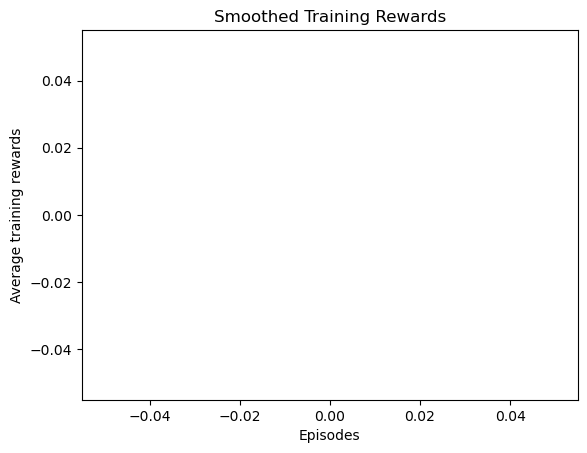

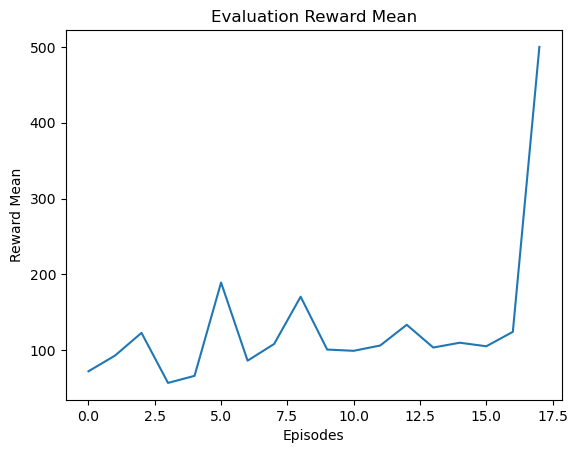

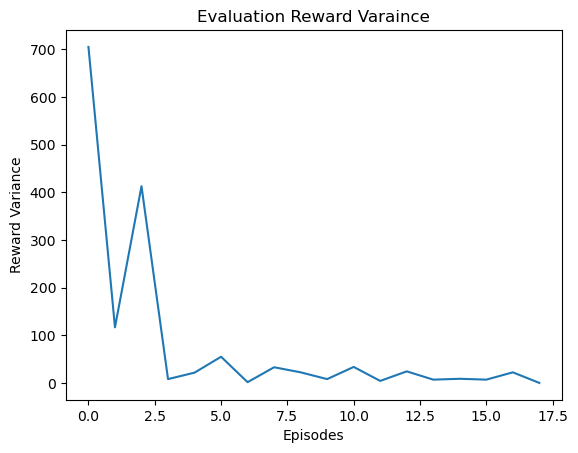

In [23]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...
plot_smoothed_training_rwd(train_reward_lst, window_size=20)
plot_eval_rwd_mean(eval_reward_mean_lst)
plot_eval_rwd_var(eval_reward_var_lst)

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...


# Naive DQN - Alternative
You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

In [24]:
def save_model(train_reward, eval_mean, eval_var, model, model_name):
  np.savetxt(f"{model_name}_train_reward.csv", train_reward, delimiter=",", fmt='%s')
  np.savetxt(f"{model_name}_eval_mean.csv", eval_mean, delimiter=",", fmt='%s')
  np.savetxt(f"{model_name}_eval_var.csv", eval_var, delimiter=",", fmt='%s')
  model.save(f"{model_name}.keras")


In [31]:
# [Write Code]
lr =  0.1     #@param {type:"number"}               # learning rate
epoch =  16     #@param {type:"number"}               # epochs
episode = 500  #@param {type:"number"}               # episodes

epsilon = 0.9           #@param {type:"number"}     # Starting exploration rate
epsilon_min = 0.1    #@param {type:"number"}     # Exploration rate min
epsilon_decay = 0.995     #@param {type:"number"}     # Exploration rate decay

gamma = 0.99          #@param {type:"number"}     # Agent discount factor

# Use the following set of NN hyperparameters for Naive DQN, DQN and DDQN policies
ba =  32       #@param {type:"number"}               # batch_size

# Use the following set of RL hyperparameters for DQN and DDQN policies
target_update_freq = 100 # @param {type:"number"}    # Target network update frequency

In [32]:
# Naive DQN Alternative Model (but same structure anyway)
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.initializers import RandomUniform

state_size = (4,) # Number of observations (CartPole)
action_size = 2        # Number of possible actions

# [WriteCode] from ... import ...
from keras.optimizers import Adam
# Define the Q-network
alt_model = Sequential()

# [WriteCode]
# model.add(...
alt_model.add(Input(shape=state_size))
initialiser = RandomUniform(minval=-0.5, maxval=0.5, seed=42)
initialiser_1 = RandomUniform(minval=-5, maxval=5, seed=42)
alt_model.add(Dense(32, activation='tanh', kernel_initializer=initialiser))  # First hidden layer
alt_model.add(Dense(32, activation='tanh', kernel_initializer=initialiser_1))  # Second hidden layer
alt_model.add(Dense(action_size))  # Output layer (Q-values for each action)

# Compile the model
# [WriteCode]
alt_model.compile(optimizer='Adam', loss='mean_squared_error')

# Print the model summary
# [WriteCode]
alt_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "naive_dqn_baseline"  # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# For timing training
total_training_time = 0

# Define replay buffer
# [WriteCode]
replay_buffer = deque(maxlen=10000)

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]
        store_experience(replay_buffer, state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        if done:
            break


        if len(replay_buffer) >= ba:
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Q-Learning update:  Q(s, a) = r + gamma * max Q(s', a')
            # [WriteCode]
            # Sample a mini-batch
            states, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)

            # Compute target Q-values
            q_targets = rewards + (gamma * np.amax(model.predict(next_states, verbose=0), axis=1)) * (1 - dones)

            # Predict current Q-values for states
            q_values = model.predict(states, verbose=0)

            # Update Q-value for the taken action
            for i, action in enumerate(actions):
                q_values[i][action] = q_targets[i]

            # Fit the model to the updated Q-values
            model.fit(states, q_values, epochs=epoch, verbose=0, callbacks=[cb])


            # Hints:

            # 1. Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * max(Q(next_state, a))

            # 2. Predict current Q-values for state
            # Update only the Q-value for the taken action

            # 3. Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)

            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]
    eval_reward_mean, eval_reward_var = evaluation(model)


    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}"
        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
    eval_reward_mean_lst.append(eval_reward_mean)
    eval_reward_var_lst.append(eval_reward_var)
    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
    if eval_reward_mean >= 500: # [Modify this threshold as needed]
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break

# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")


env.close()

Episode 1/500 | Ep. Total Reward: 33.0 | Epsilon : 0.895 | Eval Rwd Mean: 337.00 | Eval Rwd Var: 292.67
Episode 2/500 | Ep. Total Reward: 18.0 | Epsilon : 0.822 | Eval Rwd Mean: 202.67 | Eval Rwd Var: 106.89
Episode 3/500 | Ep. Total Reward: 33.0 | Epsilon : 0.700 | Eval Rwd Mean: 500.00 | Eval Rwd Var: 0.00
Early stopping triggered at Episode 3.
Training time: 0.0352 seconds per episode


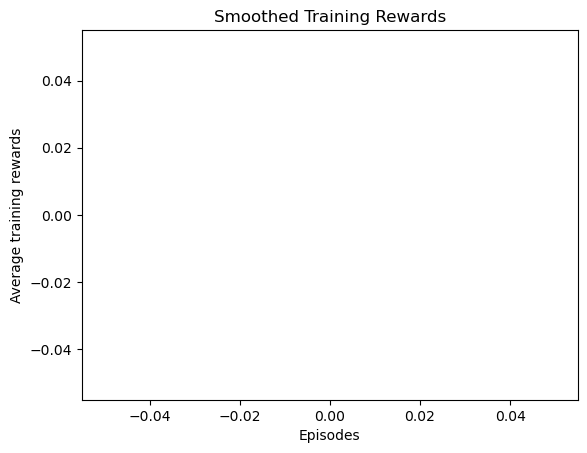

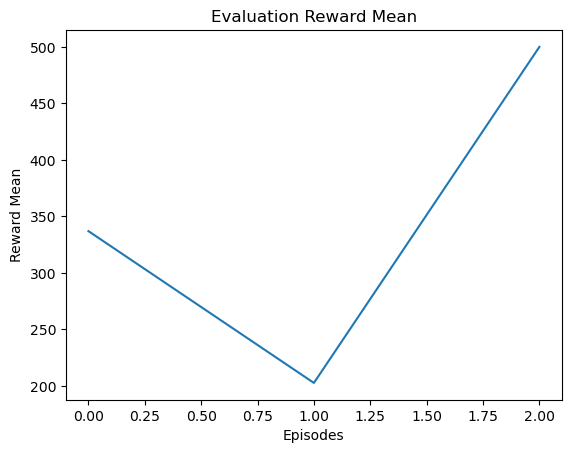

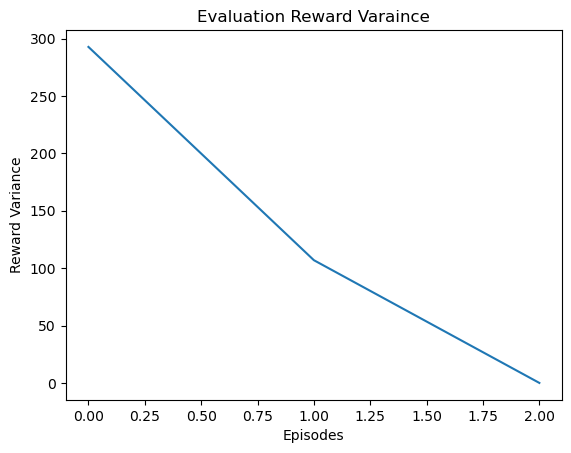

In [34]:
plot_smoothed_training_rwd(train_reward_lst, window_size=20)
plot_eval_rwd_mean(eval_reward_mean_lst)
plot_eval_rwd_var(eval_reward_var_lst)

## Comparison

Compare performance of the Baseline and the Alternative Naive DQN Policies

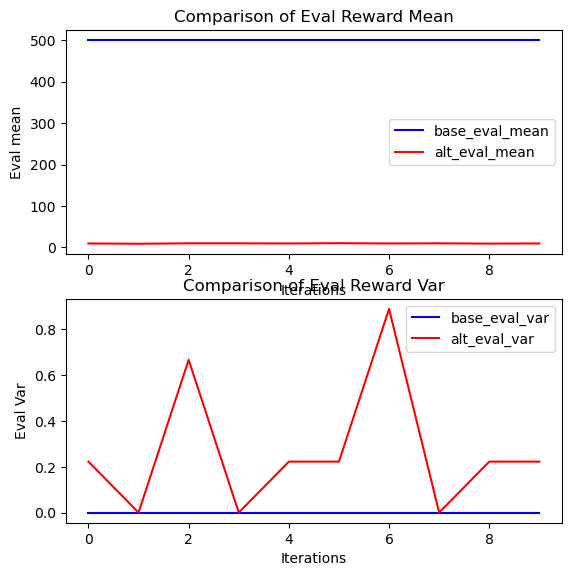

In [35]:
# [Write Code]
ITERATIONS = 10

base_eval_mean = []
base_eval_var = []
alt_eval_mean = []
alt_eval_var = []

for i in range(ITERATIONS):
    eval_mean, eval_var = evaluation(model)
    base_eval_mean.append(eval_mean)
    base_eval_var.append(eval_var)
    
    eval_mean, eval_var = evaluation(alt_model)
    alt_eval_mean.append(eval_mean)
    alt_eval_var.append(eval_var)

def plot_evaluation_metrics(base_eval_mean, base_eval_var, alt_eval_mean, alt_eval_var, iterations):
  plt.figure(figsize=(6.4,6.4))
  plt.subplot(2, 1, 1)
  plt.plot([i for i in range(iterations)], base_eval_mean, label="base_eval_mean", color="blue")
  plt.plot([i for i in range(iterations)], alt_eval_mean, label="alt_eval_mean", color="red")
  plt.xlabel("Iterations")
  plt.ylabel("Eval mean")
  plt.title("Comparison of Eval Reward Mean")
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot([i for i in range(iterations)], base_eval_var, label="base_eval_var", color="blue")
  plt.plot([i for i in range(iterations)], alt_eval_var, label="alt_eval_var", color="red")
  plt.xlabel("Iterations")
  plt.ylabel("Eval Var")
  plt.title("Comparison of Eval Reward Var")
  plt.legend()

  plt.show()


plot_evaluation_metrics(base_eval_mean, base_eval_var, alt_eval_mean, alt_eval_var, ITERATIONS)



In [36]:
def save_model(train_reward, eval_mean, eval_var, model, model_name):
  np.savetxt(f"{model_name}_train_reward.csv", train_reward, delimiter=",", fmt='%s')
  np.savetxt(f"{model_name}_eval_mean.csv", eval_mean, delimiter=",", fmt='%s')
  np.savetxt(f"{model_name}_eval_var.csv", eval_var, delimiter=",", fmt='%s')
  model.save(f"{model_name}.keras")

# DQN

In this section, you will complete the DQN algorithm by implementing the missing components marked as `[WriteCode]`.


## Define and Compile the Neural Networks

The standard DQN [https://arxiv.org/abs/1312.5602] approach features a periodically updated target network to stabilize training:

- `target_model`: A periodically updated network that stabilizes training. During training, this network is used to compute $Q(S_{t+1}, a)$ for each possible action $a$. This network is not actively trained, but at regular intervals, its weights are copied from `eval_model`. This prevents rapid fluctuations in target Q-values and improves learning stability.

- `eval_model`: The online learning network that interacts with the environment. During training, this network is used to compute $Q(S_{t}, a)$ for each possible action $a$. It updates its weights by minimizing the difference between predicted and target Q-values, improving the agent's decision-making over time.

The target used by DQN is then:

$Y^{Q}_t = R_{t+1} + \gamma \max_a Q_{target}(S_{t+1}, a)$

In the following section, define `[eval_model]` and `[target_model]` with identical architectures.

In [ ]:
# DQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...

# Define the eval (online) network
eval_model = Sequential()

# [WriteCode]
# model.add(...

# Compile the model
# [WriteCode]

# Print the model summary
# [WriteCode]


# Create target_model with the same architecture
target_model = Sequential()

# [WriteCode]
# model.add(...

# Skip compiling as target_model will not be trained with .fit()
# Instead, weights will be copied from the online model
target_model.set_weights(eval_model.get_weights())

# Print the model summary
# [WriteCode]
print(target_model.summary())

## Set Up Env and Train the Policy

In this section, you will complete the DQN training routine by implementing the missing components marked as `[WriteCode]`.




In [ ]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "dqn_baseline"   # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# Train Counter for weight syncing
train_counter = 0

# For timing training
total_training_time = 0

# Define replay buffer
# replay_buffer = ...

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            q_values = eval_model.predict(state, verbose=0)
            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]

        state = next_state
        total_reward += reward

        if done:
            break

        if len(replay_buffer) >= ba:
            train_counter += 1
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Deep Q-Learning update: Q(s, a) = r + gamma * max Q_target(S', a)
            # [WriteCode]

            # Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * max(Q_target(next_state, a))

            # Predict current Q-values for state using eval_model
            # Predict future Q-values using target_model (NOT eval_model)

            # Update only the Q-value for the taken action

            # Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)


            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            # Periodically update the target network
            if train_counter % target_update_freq == 0:
                target_model.set_weights(eval_model.get_weights())

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]


    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}"
        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
    eval_reward_mean_lst.append(eval_reward_mean)
    eval_reward_var_lst.append(eval_reward_var)
    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
    if eval_reward_mean > 500: # [Modify this threshold as needed]
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break

# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")

env.close()

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]
plot_smoothed_training_rwd(train_reward_lst, window_size=20)
plot_eval_rwd_mean(eval_reward_mean_lst)
plot_eval_rwd_var(eval_reward_var_lst)

# DQN - Alternative

You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...

In [ ]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative DQN Policies

In [ ]:
# [Write Code]

# DDQN

## Define and Compile the Neural Networks

The Double Deep Q-Network (DDQN) [https://arxiv.org/abs/1509.06461] improves upon standard DQN by reducing overestimation bias in Q-values. DDQN achieves this by decoupling action selection from value estimation using two networks, which is almost identical as DQN:

- `target_model`: A periodically updated network that stabilizes training. During training, this network is used to compute $Q(S_{t+1}, a)$ for each possible action $a$. This network is also not trained but synced from `eval_model`. **However, unlike DQN, this network is only used to evaluate the Q-value of the action chosen by `eval_model`, making value updates more stable.**

- `eval_model`: The online learning network that interacts with the environment. During training, this network is used to select the best action using $\arg\max_a Q(S_{t}, a)$ and updates its weights by minimizing the difference between predicted and target Q-value.

The target used by DDQN is then:

$Y^{Q}_t = R_{t+1} + \gamma Q_{target}(S_{t+1}, \arg \max_{a} Q_{eval}(S_{t+1}, a))$

In [ ]:
# DDQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...

# Define the eval (online) network
eval_model = Sequential()

# [WriteCode]
# model.add(...

# Compile the model
# [WriteCode]

# Print the model summary
# [WriteCode]



# Create target_model with the same architecture
target_model = Sequential()

# [WriteCode]
# model.add(...

# Skip compiling as target_model will not be trained with .fit()
# Instead, weights will be copied from the online model
target_model.set_weights(eval_model.get_weights())

# Print the model summary
# [WriteCode]

## Set Up Env and Train the Policy

In [ ]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "ddqn_baseline"  # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# Train Counter for weight syncing
train_counter = 0

# For timing training
total_training_time = 0

# Define replay buffer
# replay_buffer = ...

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):

        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            q_values = eval_model.predict(state, verbose=0)
            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]

        state = next_state
        total_reward += reward

        if done:
            break

        if len(replay_buffer) >= ba:
            train_counter += 1
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Double Deep Q-Learning update:
            # Q(s, a) = r + gamma * Q_target(S', argmax Q_eval(S', a))
            # [WriteCode]

            # Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * Q_target(S', argmax Q_eval(S', a))

            # Predict current Q-values for state using eval_model
            # Use eval_model to determine best action in next_state
            # Use target_model to compute Q-value for that action

            # Update only the Q-value for the taken action

            # Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)


            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            # Periodically update the target network
            if train_counter % target_update_freq == 0:
                target_model.set_weights(eval_model.get_weights())

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]


    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}"
        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
    eval_reward_mean_lst.append(eval_reward_mean)
    eval_reward_var_lst.append(eval_reward_var)
    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
    if eval_reward_mean > 500: # [Modify this threshold as needed]
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break

# record end time and calculate average training time per episode
# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")

env.close()

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...

# DDQN - Alternative

You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

In [ ]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative DDQN Policies

In [ ]:
# [Write Code]

# Visualize with Tensorboard

In [17]:
%tensorboard --logdir=./ee4802_logs --port=6006

Reusing TensorBoard on port 6006 (pid 94189), started 2 days, 19:49:04 ago. (Use '!kill 94189' to kill it.)

# Comparison Across Four Alternative Policies

Compare hyperparameters and performance of the four alternative policies.

You may insert extra cells in the notebook to tabulate/plot/log results effectively.

In [ ]:
# [Write Code]